In [1]:
import pandas as pd
import os, time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from epftoolbox.evaluation import MAE, MAPE, RMSE, rMAE
from sklearn import metrics

In [2]:
os.chdir('..')
tf.random.set_seed(123)

In [3]:
# Funciones auxiliares
# Romper el dataset
def train_test_vali(serie, train_size, valida_size, ts_size):
    total_data = serie.shape[0]

    train_data = int(total_data * train_size)
    valid_data = int(total_data * valida_size)
    test_data = total_data - train_data - valid_data

    train = serie[0:train_data]
    vali = serie[train_data:train_data + valid_data]
    test = serie[train_data + valid_data:]
    return train, vali, test

#Crear dataset supervisado
def crear_dataset_supervisado(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

# Escalamiento de los datos
def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]

# Auxiliares del modelo
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

def predecir(x, model, scaler, y_real, OUTPUT_LENGTH):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)
    y_real = scaler.inverse_transform(y_real.reshape(-1, OUTPUT_LENGTH))

    return y_pred.flatten(), y_real.flatten()

# Función para medir el tiempo de ejecución
def elapsed_time(start_time):
    return time.time() - start_time

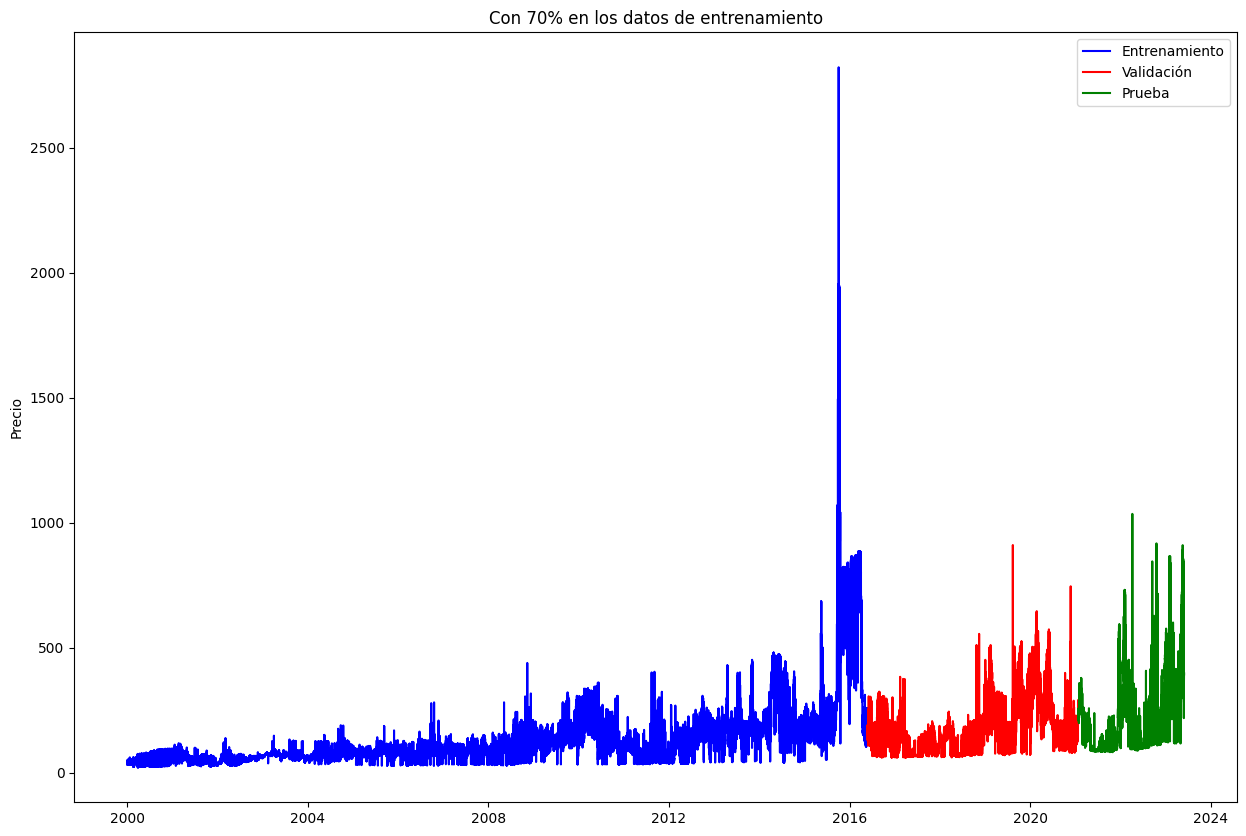

Epoch 1/50
543/543 [==============================] - 17s 21ms/step - loss: 0.8731 - val_loss: 0.7592
Epoch 2/50
543/543 [==============================] - 11s 20ms/step - loss: 0.7063 - val_loss: 0.5685
Epoch 3/50
543/543 [==============================] - 11s 19ms/step - loss: 0.4965 - val_loss: 0.3753
Epoch 4/50
543/543 [==============================] - 11s 19ms/step - loss: 0.3244 - val_loss: 0.2370
Epoch 5/50
543/543 [==============================] - 10s 19ms/step - loss: 0.1969 - val_loss: 0.1262
Epoch 6/50
543/543 [==============================] - 10s 19ms/step - loss: 0.0896 - val_loss: 0.0384
Epoch 7/50
543/543 [==============================] - 11s 19ms/step - loss: 0.0344 - val_loss: 0.0288
Epoch 8/50
543/543 [==============================] - 10s 19ms/step - loss: 0.0286 - val_loss: 0.0261
Epoch 9/50
543/543 [==============================] - 11s 20ms/step - loss: 0.0268 - val_loss: 0.0249
Epoch 10/50
543/543 [==============================] - 10s 19ms/step - loss: 0.026

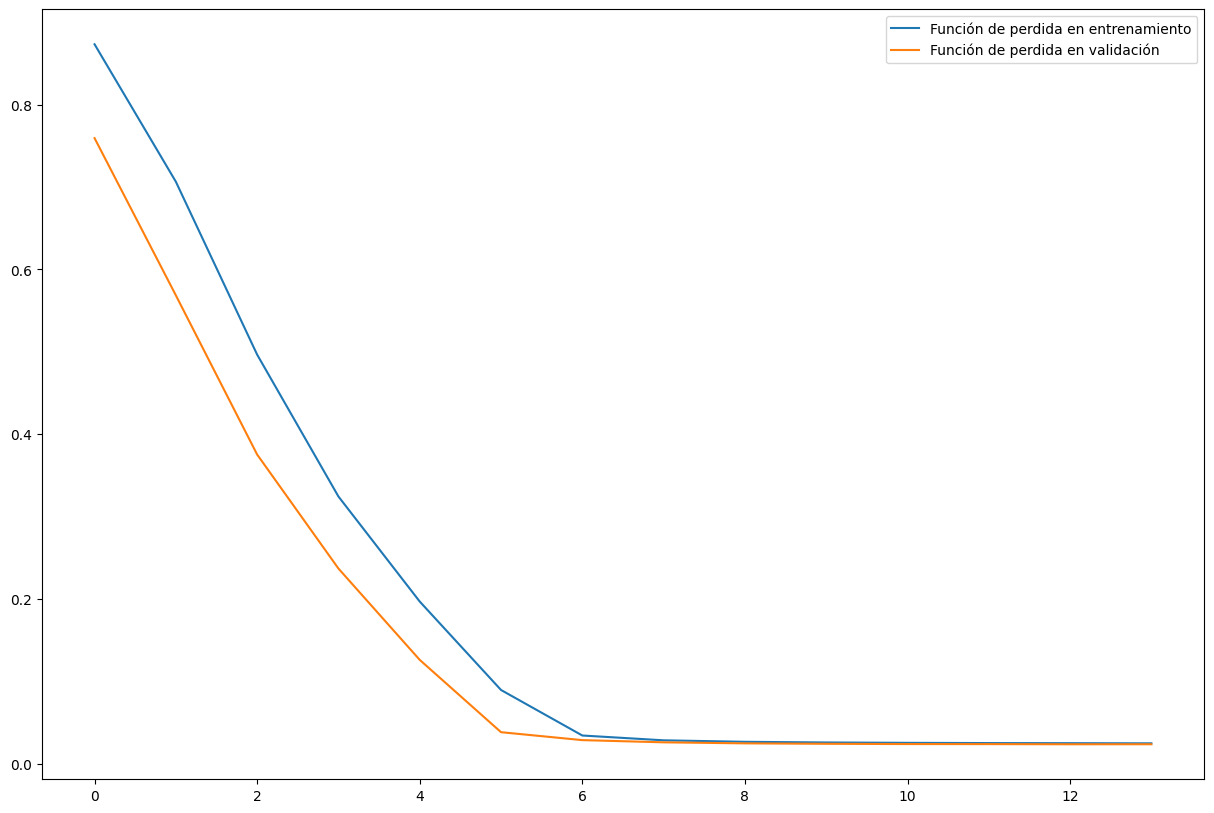

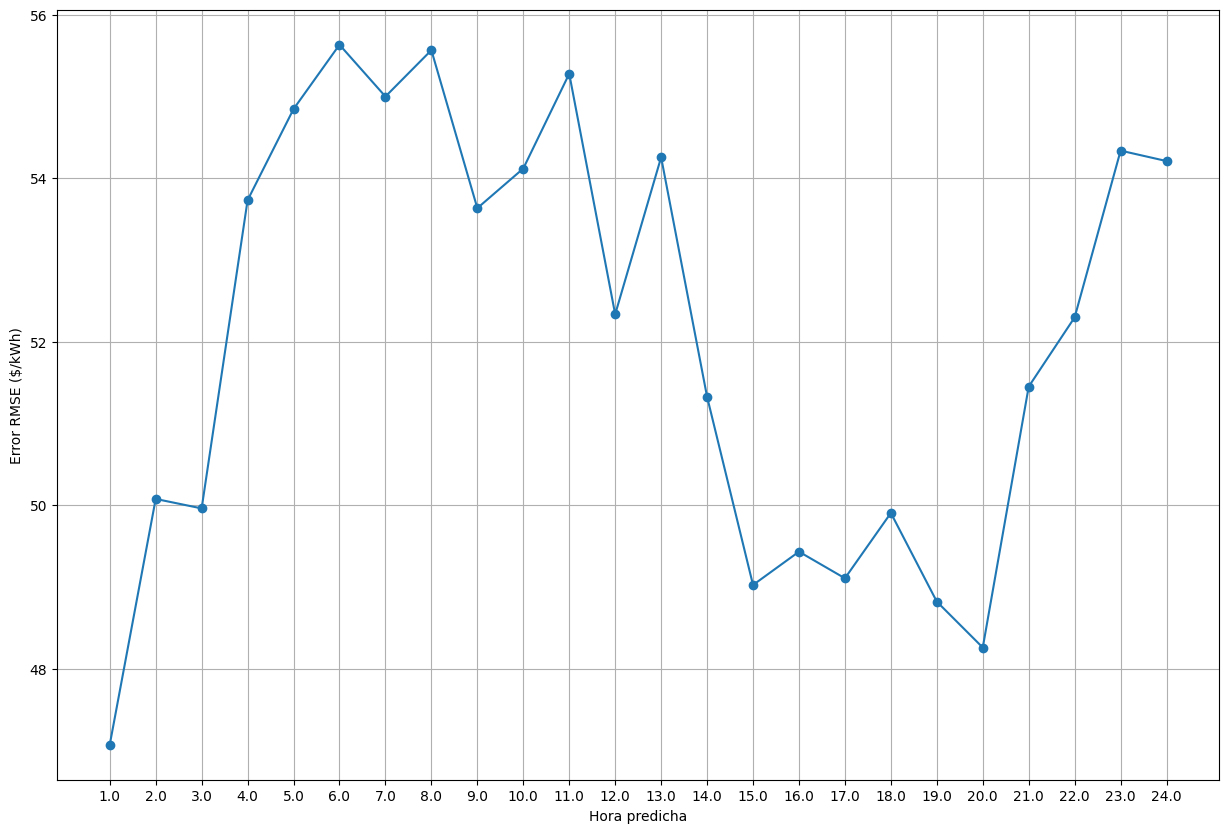

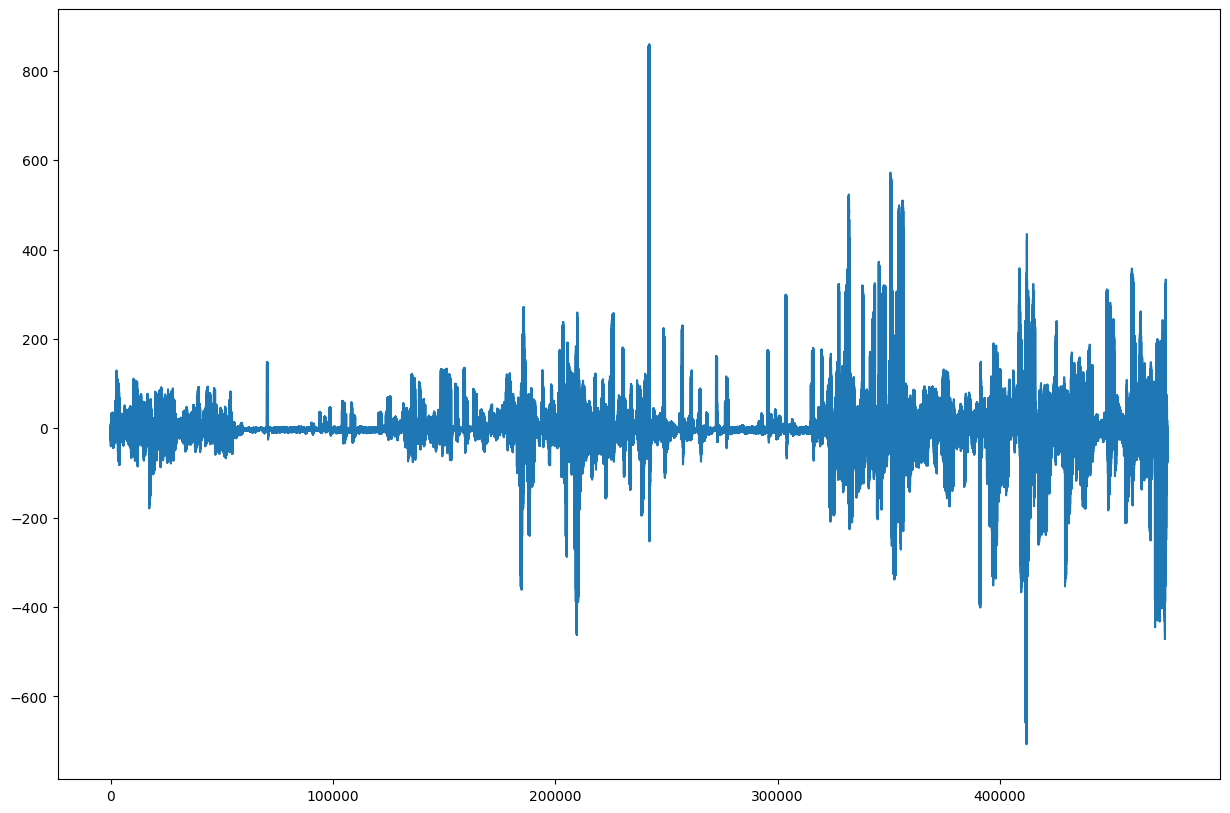

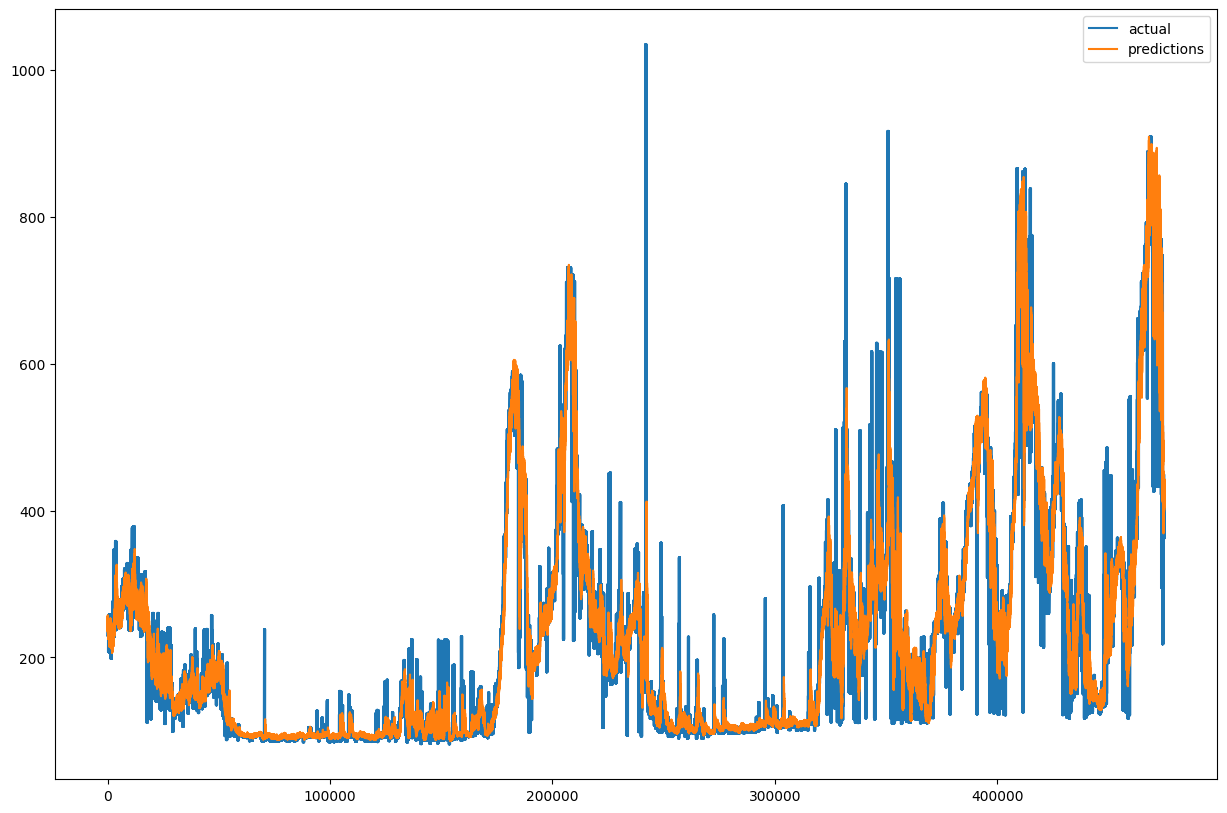

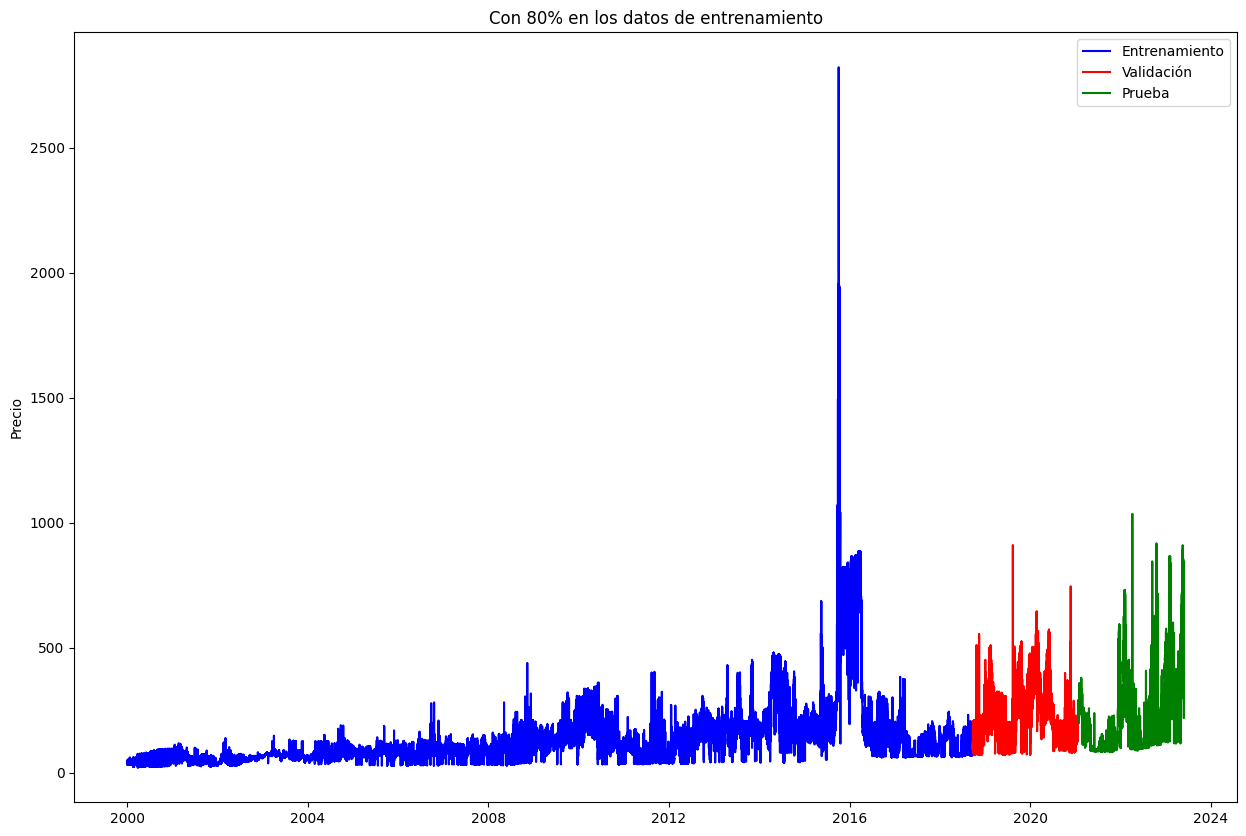

Epoch 1/50
621/621 [==============================] - 18s 19ms/step - loss: 0.8924 - val_loss: 0.7533
Epoch 2/50
621/621 [==============================] - 11s 18ms/step - loss: 0.7162 - val_loss: 0.5253
Epoch 3/50
621/621 [==============================] - 11s 18ms/step - loss: 0.4522 - val_loss: 0.2837
Epoch 4/50
621/621 [==============================] - 11s 18ms/step - loss: 0.2066 - val_loss: 0.0932
Epoch 5/50
621/621 [==============================] - 11s 18ms/step - loss: 0.0570 - val_loss: 0.0445
Epoch 6/50
621/621 [==============================] - 11s 18ms/step - loss: 0.0297 - val_loss: 0.0357
Epoch 7/50
621/621 [==============================] - 11s 18ms/step - loss: 0.0263 - val_loss: 0.0335
Epoch 8/50
621/621 [==============================] - 11s 18ms/step - loss: 0.0256 - val_loss: 0.0323
Epoch 9/50
621/621 [==============================] - 11s 18ms/step - loss: 0.0253 - val_loss: 0.0320
Epoch 10/50
621/621 [==============================] - 10s 17ms/step - loss: 0.025

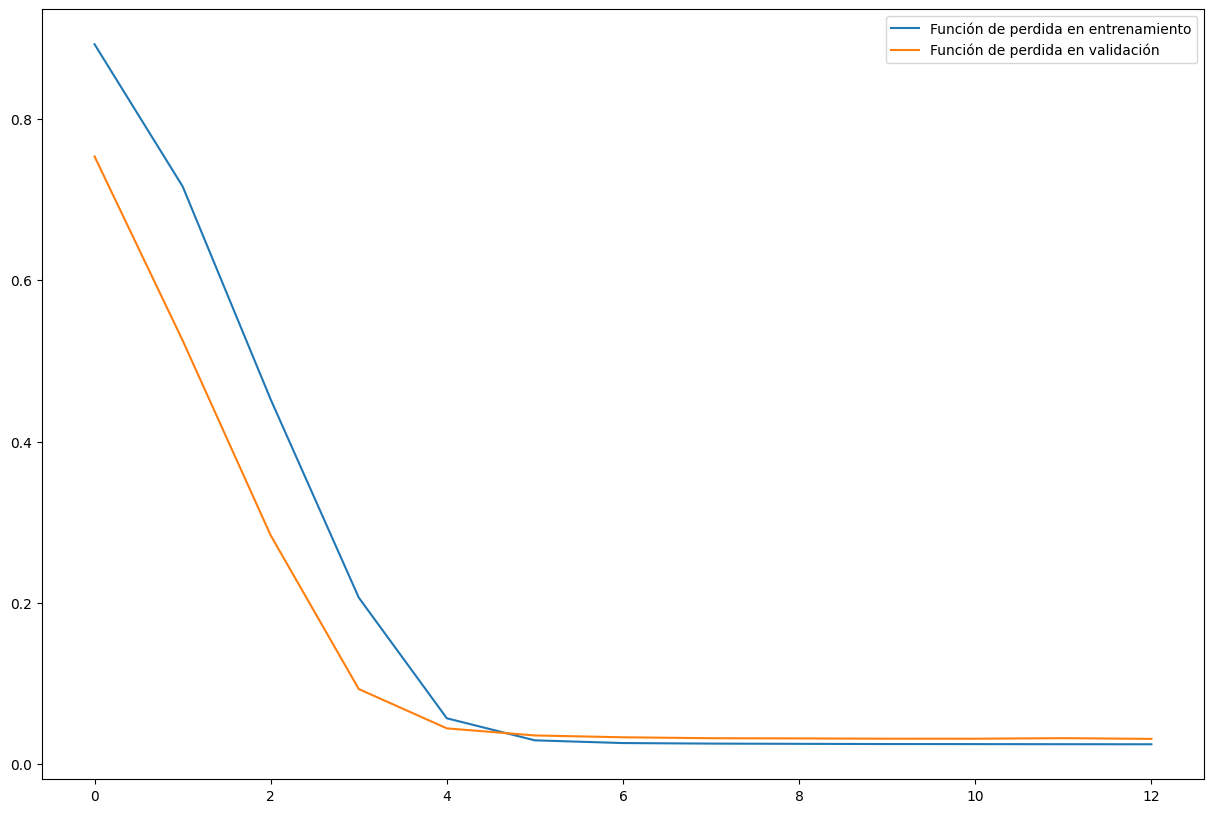

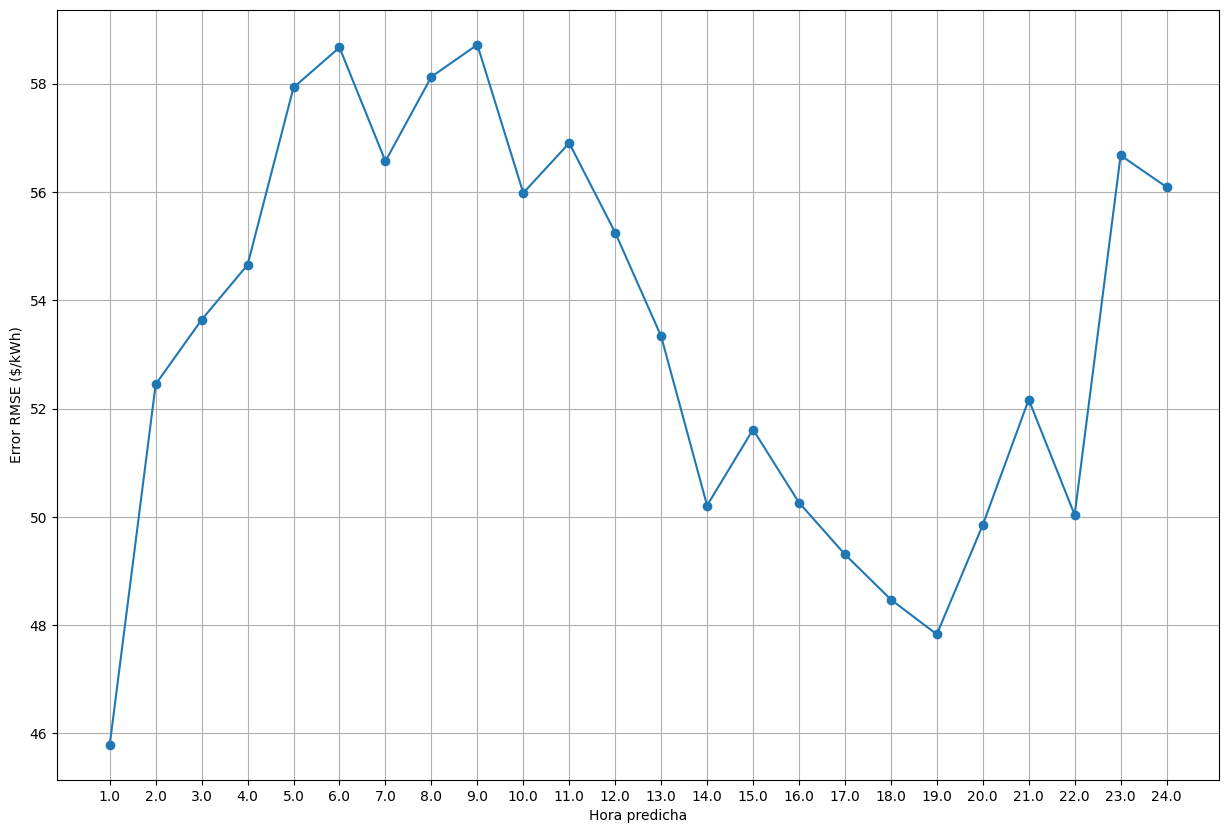

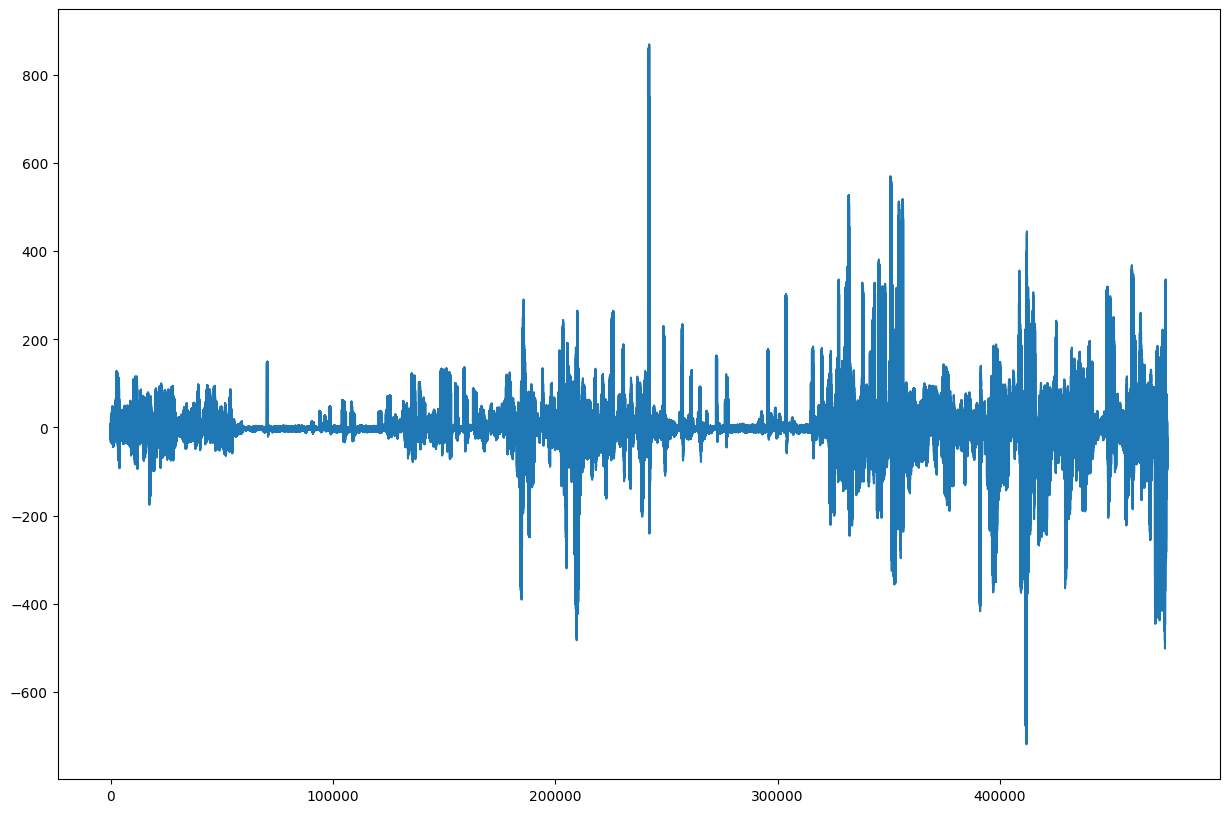

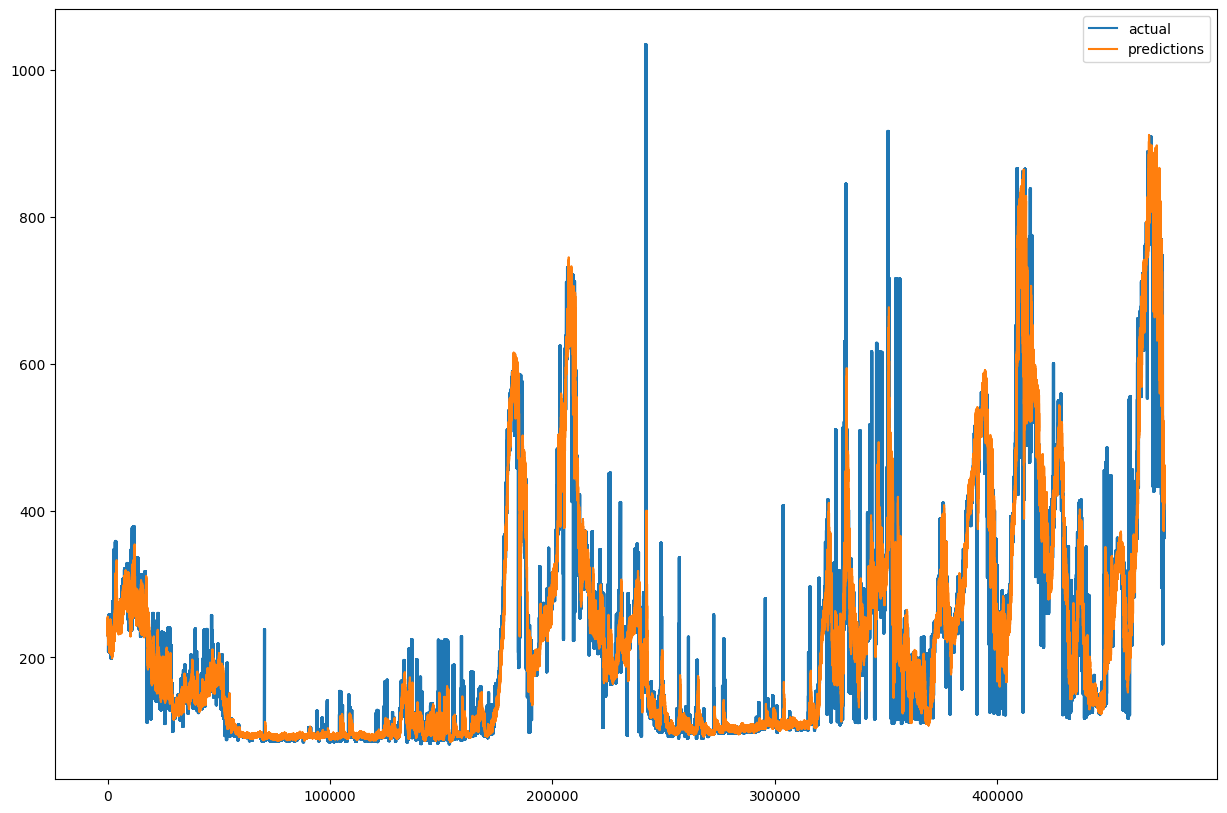

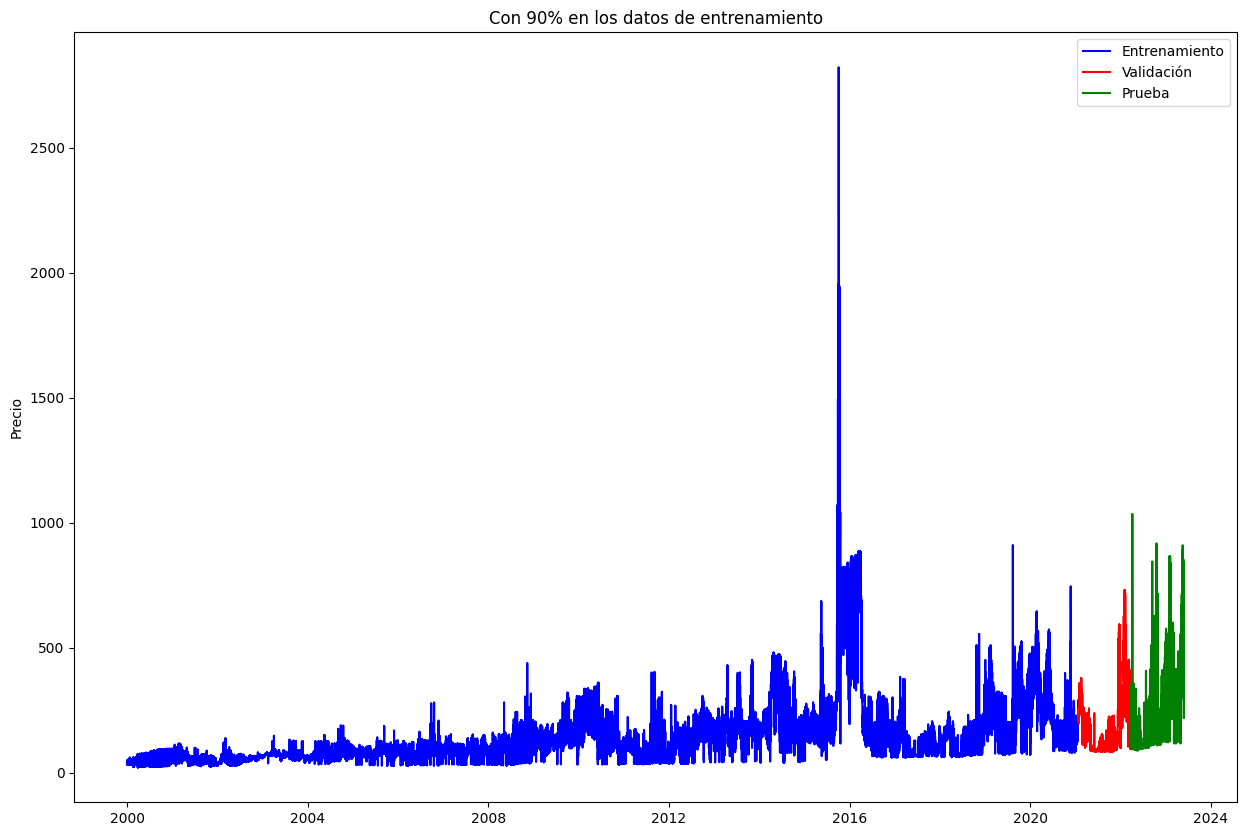

Epoch 1/50
698/698 [==============================] - 18s 20ms/step - loss: 0.7779 - val_loss: 0.5777
Epoch 2/50
698/698 [==============================] - 12s 17ms/step - loss: 0.4025 - val_loss: 0.1995
Epoch 3/50
698/698 [==============================] - 13s 18ms/step - loss: 0.1075 - val_loss: 0.0379
Epoch 4/50
698/698 [==============================] - 13s 18ms/step - loss: 0.0357 - val_loss: 0.0221
Epoch 5/50
698/698 [==============================] - 12s 18ms/step - loss: 0.0279 - val_loss: 0.0202
Epoch 6/50
698/698 [==============================] - 12s 17ms/step - loss: 0.0270 - val_loss: 0.0198
Epoch 7/50
698/698 [==============================] - 11s 15ms/step - loss: 0.0266 - val_loss: 0.0196
Epoch 8/50
698/698 [==============================] - 12s 17ms/step - loss: 0.0265 - val_loss: 0.0193
Epoch 9/50
698/698 [==============================] - 12s 17ms/step - loss: 0.0263 - val_loss: 0.0192


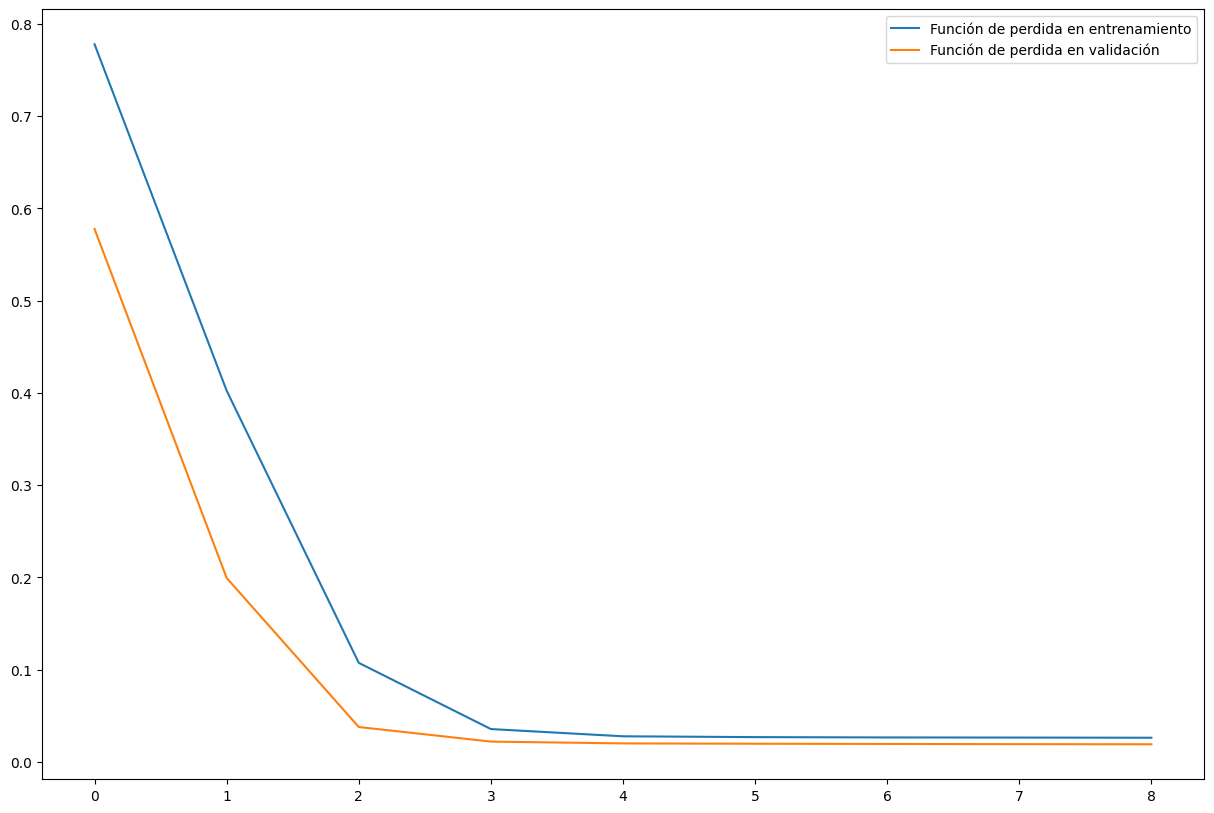

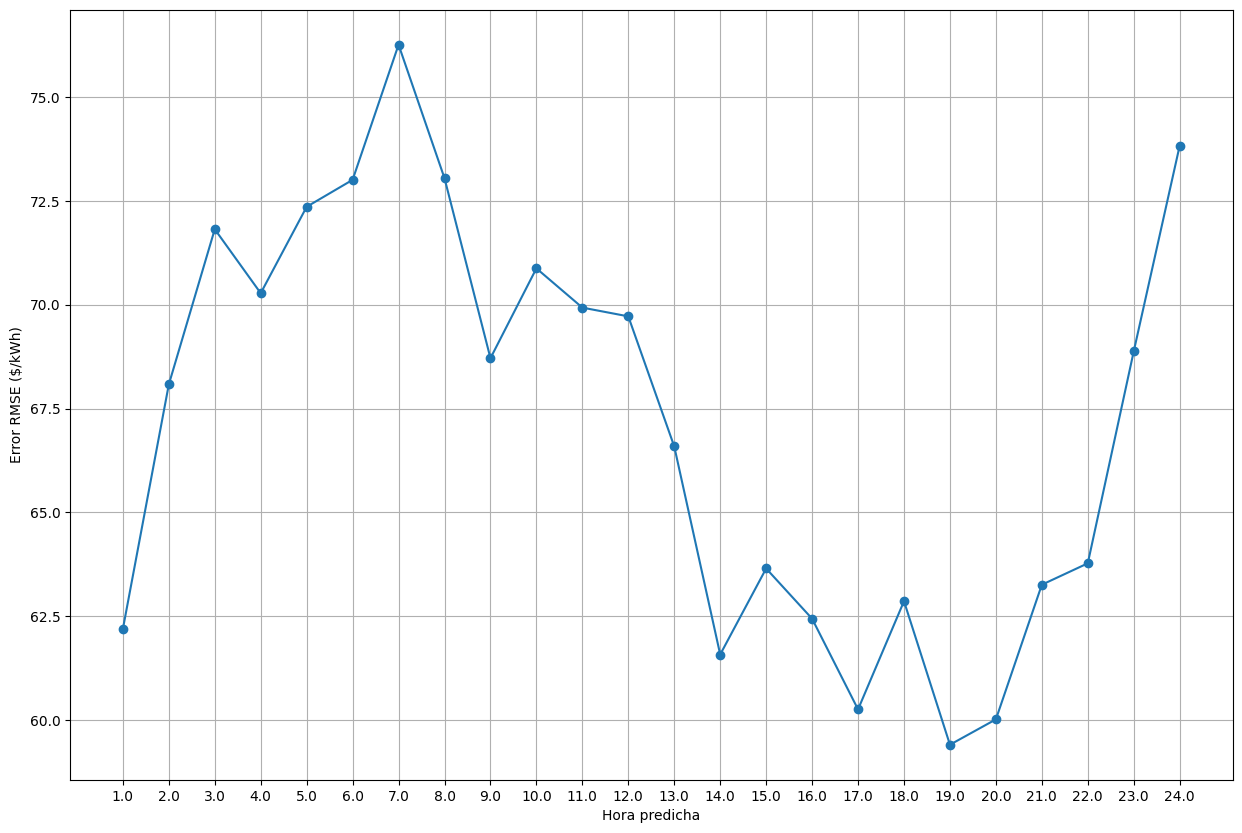

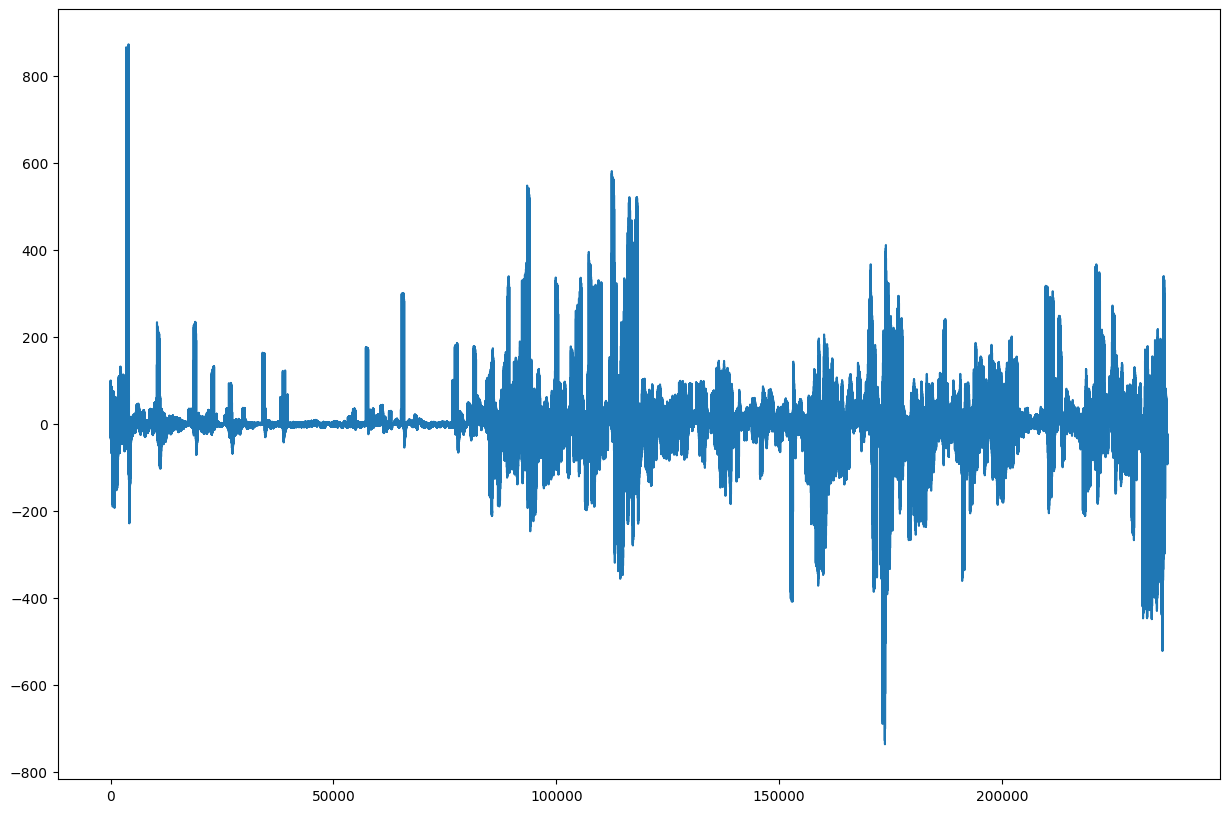

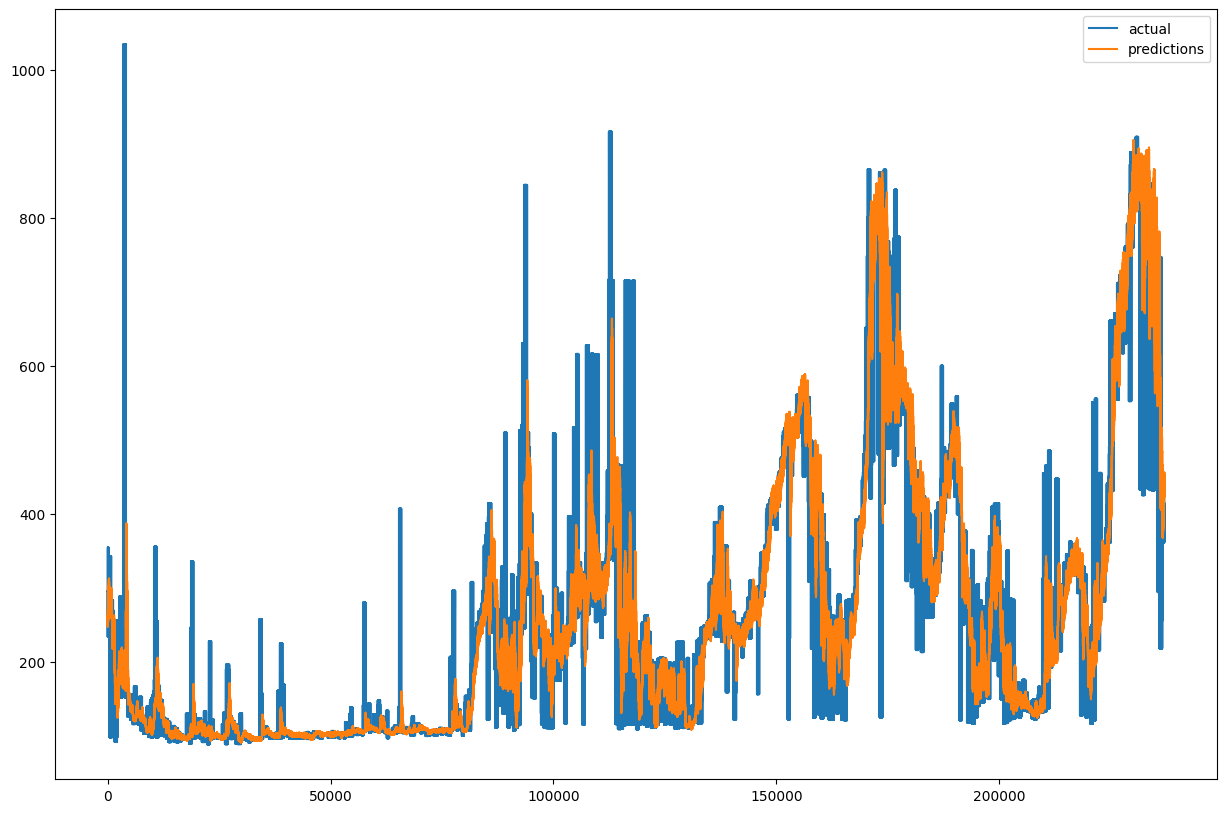

In [5]:
# Crear diferentes modelos base para cada tipo de particion
types = [(0.7,0.2,0.1),(0.8,0.1,0.1),(0.9,0.05,0.05)]
lista_results = []
INPUT_LENGTH = 24    # Registros de 24 horas consecutivas a la entrada
OUTPUT_LENGTH = 24   # El modelo va a predecir 24 horas a futuro
for i in types:
    df = pd.read_csv('df_data_colum.csv', parse_dates=['date_hour'], index_col='date_hour')
    tr, vl, ts = train_test_vali(df['price'], i[0], i[1], i[2])
    plt.figure(figsize=(15,10))
    plt.plot(tr, color='blue', label='Entrenamiento')
    plt.plot(vl, color='red', label='Validación')
    plt.plot(ts, color='green', label='Prueba')
    plt.ylabel('Precio')
    plt.title(f'Con {int(i[0]*100)}% en los datos de entrenamiento')
    plt.legend()
    plt.show()
    # Convertir a un problema supervisado
    x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
    x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
    x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)
    data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
    }
    # Escalar los datos
    data_s, scaler = escalar_dataset(data_in)
    x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
    x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
    x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

    # Creacion del modelo
    optimizador = RMSprop(learning_rate=5e-5)
    modelo = Sequential()
    modelo.add(LSTM(16, input_shape=(x_tr_s.shape[1], x_tr_s.shape[2])))
    modelo.add(Dense(OUTPUT_LENGTH, activation='linear'))
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.003)
    modelo.compile(
        optimizer = optimizador,
        loss = root_mean_squared_error
    )
    # Entrenamiento del modelo
    start_time = time.time()

    historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = 256,
    epochs = 50,
    validation_data = (x_vl_s, y_vl_s),
    verbose=1, 
    callbacks=[early_stopping]
    )
    training_time = elapsed_time(start_time)
    # Comparativa de modelos
    rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
    rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
    rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

    df_history = pd.DataFrame(historia.history)
    x = df_history.index
    plt.figure(figsize=(15, 10))
    plt.plot(x, df_history['loss'], label='Función de perdida en entrenamiento')
    plt.plot(x, df_history['val_loss'], label='Función de perdida en validación')
    plt.legend()

    # Hacer predicciones
    start_time = time.time()
    y_ts_pred, y_real = predecir(x_ts_s, modelo, scaler, y_ts_s, OUTPUT_LENGTH)
    prediction_time = elapsed_time(start_time)

    # Grafico de error (rmse) promedio por hora
    y_ts_pred_s = modelo.predict(x_ts_s, verbose=0)
    y_ts_pred = scaler.inverse_transform(y_ts_pred_s)
    diff_cuad = np.square(y_ts.squeeze()-y_ts_pred) # 
    proms = np.mean(diff_cuad, axis=0) # 1x4
    rmse = np.sqrt(proms) # 1x4
    t = np.linspace(1,24,24)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(t,rmse, marker='o')
    ax.set_xlabel('Hora predicha')
    ax.set_ylabel('Error RMSE ($/kWh)')
    plt.xticks(ticks=t, labels=t)
    plt.grid()

    # Grafico de errores
    N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
    ndato = np.linspace(1,N,N)
    errores = y_ts.flatten()-y_ts_pred.flatten()
    plt.figure(figsize=(15, 10))
    plt.plot(errores)

    # Grafico de predicciones
    df_result = pd.DataFrame({'predictions': y_ts_pred.flatten(), 'actual': y_real.flatten()})
    x = df_result.index
    plt.figure(figsize=(15, 10))
    plt.plot(x, df_result['actual'], label='actual')
    plt.plot(x, df_result['predictions'], label='predictions')
    plt.legend()

    # Guardar el modelo
    modelo.save('lstm_model/bases_model/model_{train_size}.h5'.format(train_size=i[0]))

    # Evaluar el modelo
    mean_MAE = MAE(p_pred= df_result['predictions'], p_real=df_result['actual'])
    mean_RMSE = RMSE(p_pred= df_result['predictions'], p_real=df_result['actual'])
    mean_MAPE = MAPE(p_pred= df_result['predictions'], p_real=df_result['actual']) * 100
    mean_rMAE = rMAE(p_pred= np.array(df_result['predictions']), p_real=np.array(df_result['actual']), m='D')
    r2 = metrics.r2_score(y_real.flatten(), y_ts_pred.flatten())

    results = {'trainig_size': i[0], 'model': 'lstm', 'type': 'base', 'training_time': training_time, 
               'prediction_time': prediction_time, 'rmse_trainig': rmse_tr, 'rmse_validation': rmse_vl, 'rmse_test': rmse_ts, 
               'mean_MAE': mean_MAE,  'r2': r2, 'mean_RMSE': mean_RMSE, 'mean_MAPE': mean_MAPE, 'mean_rMAE': mean_rMAE}
    
    lista_results.append(results)

df_results_bases = pd.DataFrame(lista_results)
df_results_bases.to_csv('lstm_model/bases_model/df_results_bases.csv')
        